# Time Series Analysis of Groundwater Levels and Projection of Future Trend

This project explores groundwater level data using non-parametric approaches, and forecasts future groundwater levels based on Auto Regressive Integrated Moving Average (ARIMA). Data were collected near Sunol Regional Wildness and provided by San Francisco Public Utilities Commissions (SFPUC), CA, USA.

In [2]:
# import packages to be used in this project
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
%matplotlib inline

# import data and convert column "Date" from data type "string" to "timestamp"
def parser(x):
    return datetime.strptime(x,'%m/%d/%Y')
    
gw_data = pd.read_csv("sunol_valley_groundwater.csv",parse_dates =[0], date_parser = parser)

# Part 1: Data Exploration

## Part 1.1: Understand the Raw Dataset

In [3]:
# Take a look at the first five entries. Detect features, data patterns and NaN data.
gw_data.head()

,Date,Time,Date_Time,Groundwater_Level_ft,Atm_Pressure_ft,Temp_Celsius
0,2008-07-29,0:00:00,7/29/2008 0:00,5.5720,NaN,NaN
1,2008-07-29,6:00:00,7/29/2008 6:00,5.5421,NaN,NaN
2,2008-07-29,12:00:00,7/29/2008 12:00,5.5175,NaN,NaN
3,2008-07-29,18:00:00,7/29/2008 18:00,5.5021,NaN,NaN
4,2008-07-30,0:00:00,7/30/2008 0:00,5.4860,NaN,NaN


In [4]:
# Explore data types, data size, and number of NaN data.
gw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78871 entries, 0 to 78870
Data columns (total 6 columns):
Date                    78871 non-null datetime64[ns]
Time                    78871 non-null object
Date_Time               78871 non-null object
Groundwater_Level_ft    78871 non-null float64
Atm_Pressure_ft         72977 non-null float64
Temp_Celsius            72977 non-null float64
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 3.6+ MB


We have 5,894 NaN data in columns "Atm_Pressure_ft" and "Temp_Celsius" which will be discarded from the dataset.

In [5]:
# Show the times of the first and last observations.
print('The start time is ' + gw_data.Date_Time[0])
print('The end time is ' + gw_data.Date_Time[len(gw_data.Date)-1])

The start time is 7/29/2008 0:00
The end time is 3/31/2019 10:00


## Part 1.2: Data Cleaning and Preprocessing
This part includes removing columns we do not need, checking missing values, and aggregating values by month.

### Compute Monthly Average

In [6]:
# Computer daily average groundwater level
gw_data_daily = gw_data[["Date","Groundwater_Level_ft"]].groupby(['Date']).mean()
gw_data_daily.head()

,Groundwater_Level_ft
Date,
2008-07-29,5.533425
2008-07-30,5.451425
2008-07-31,5.349025
2008-08-01,5.266600
2008-08-02,5.188750


In [7]:
# Resample to obrain monthly average data.
gw=gw_data_daily["Groundwater_Level_ft"].resample('MS').mean()
gw.head()

Date
2008-07-01    5.444625
2008-08-01    4.934582
2008-09-01    4.076669
2008-10-01    4.335801
2008-11-01    5.581205
Freq: MS, Name: Groundwater_Level_ft, dtype: float64

### Split Training and Test Set

In [8]:
train = gw[:'6/30/2018']
test = gw['7/1/2018':]
train.head(), test.head()

(Date
 2008-07-01    5.444625
 2008-08-01    4.934582
 2008-09-01    4.076669
 2008-10-01    4.335801
 2008-11-01    5.581205
 Freq: MS, Name: Groundwater_Level_ft, dtype: float64, Date
 2018-07-01    8.111841
 2018-08-01    6.514973
 2018-09-01    6.174250
 2018-10-01    5.853212
 2018-11-01    6.766306
 Freq: MS, Name: Groundwater_Level_ft, dtype: float64)

# Part 2: Data Visualization

<function matplotlib.pyplot.show(*args, **kw)>

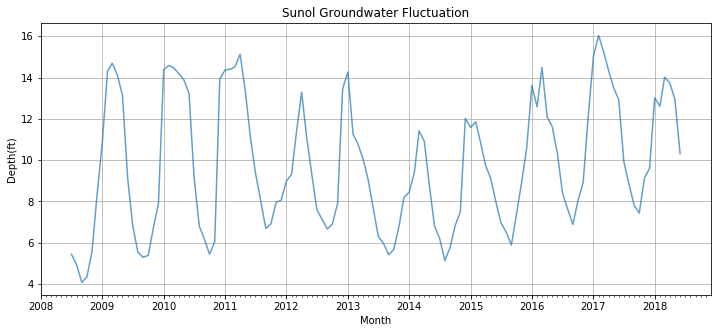

In [9]:
# Visualize the monthly average

fig, ax = plt.subplots(figsize = (12,5))
ax.plot(train,alpha = 0.7)

ax.set(xlabel='Month', ylabel = 'Depth(ft)',title = 'Sunol Groundwater Fluctuation')
years = mdates.YearLocator()
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.grid()
#ax.legend(loc = 'best')
plt.show

## Part 2.1: Time Series Decomposition

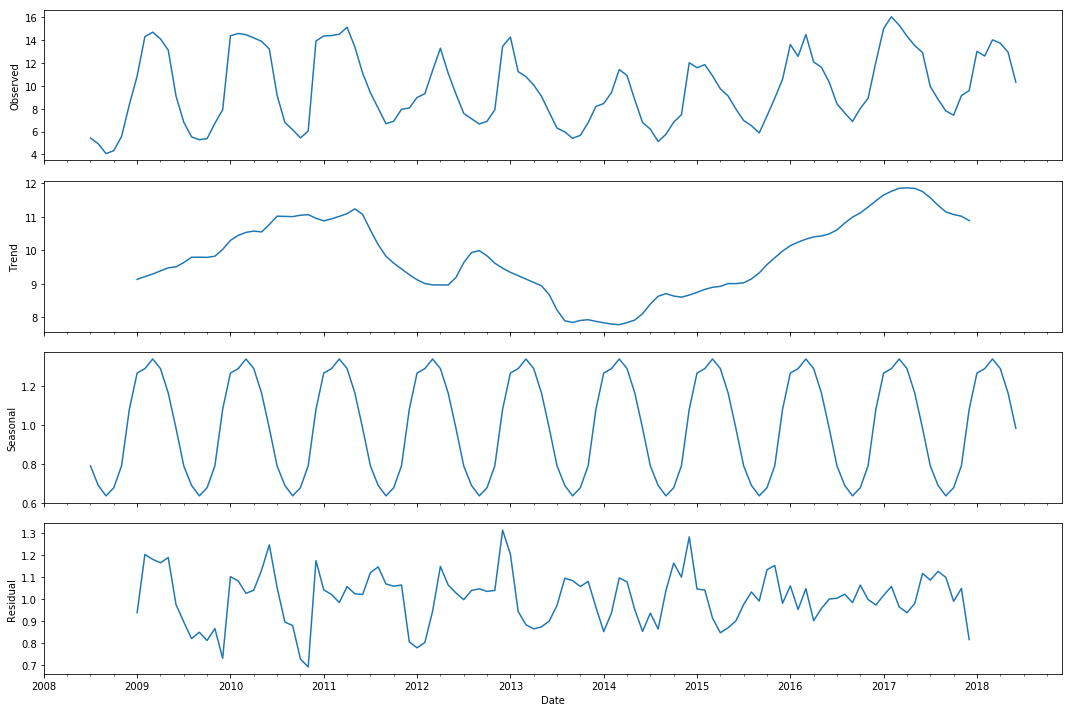

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,10
decomposition = sm.tsa.seasonal_decompose(train, model='multiplicative')
fig = decomposition.plot()
plt.show()

A series is thought to be an aggregate of four components. These components are defined as follows:
- Observed: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonal: The repeating short-term cycle in the series.
- Residual：The random variation in the series.

The plot above clearly shows that the groundwater depth is unstable, with average level increasing in the first three years, then decreasing in the next three years, and then increasing again. The "Seasonal" plot clearly shows seasonality. The "Resisual" plot shows high variability in the early years of the series. Considering there are both seasonality and non-seasonal trend in this series, we will be using Seasonal ARIMA model to perform the analysis.

# Part 3: Time Series

## Part 3.1： Check Stationarity with Augmented Dickey-Fuller Test (ADF)

In [11]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(ts):
    # Determine rolling statistics:
    rmean = ts.rolling(12).mean()
    rstd = ts.rolling(12).std()
    
    # Plot rolling statistics:
    raw = plt.plot(ts, color = 'green', label = 'Raw')
    mean = plt.plot(rmean,  color = 'red', label = 'Rolling Mean')
    std = plt.plot(rstd, color = 'blue', label = 'Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller Test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

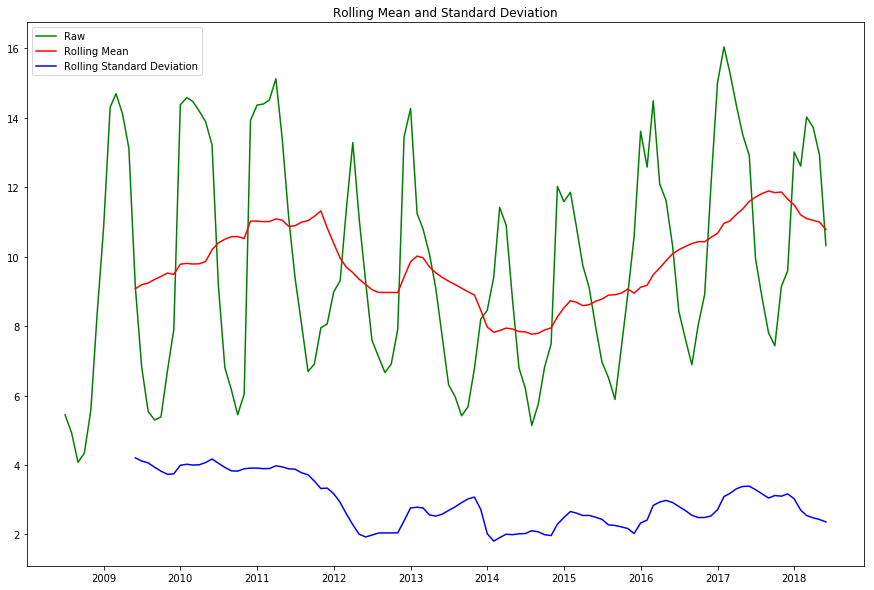

Results of Dickey-Fuller Test:
Test Statistic                  -1.302441
p-value                          0.628055
Lags Used                       10.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


In [12]:
check_stationarity(train)

Since test statistics is greater than the critical values, we cannot reject the null hypothesis that the series is non-stationary.

## Part 3.2: Differencing

- Take differencing to make the series stable. A statble series is the assumption that ACF and PACF models are based on.
- Examine the early lags(1, 2, 3, …) to judge non-seasonal terms.
- Examine the patterns across lags that are multiples of S = 12.

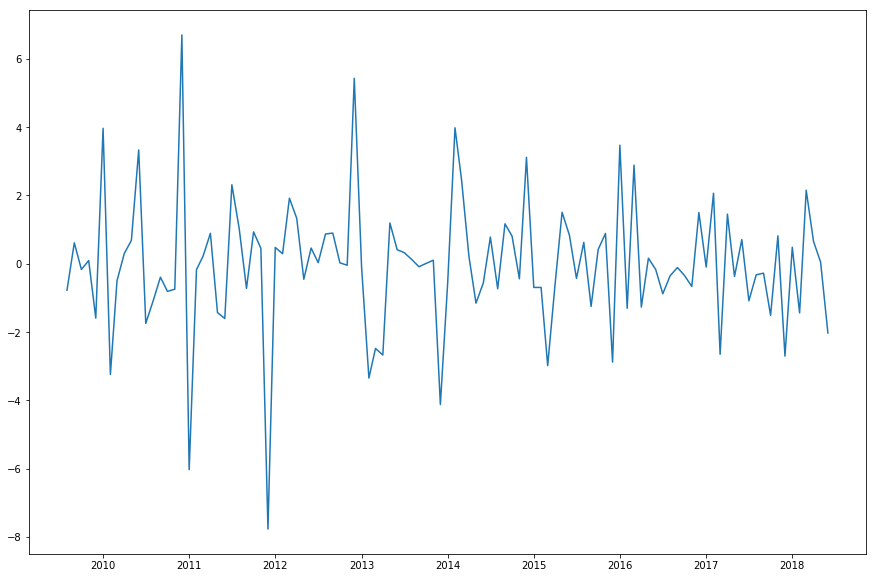

In [13]:
#log_train = np.log(train)
train_diff = (train - train.shift(12)).dropna()

train_diff = (train_diff - train_diff.shift()).dropna()
#train_diff = (train_diff - train_diff.shift()).dropna()

plt.plot(train_diff)

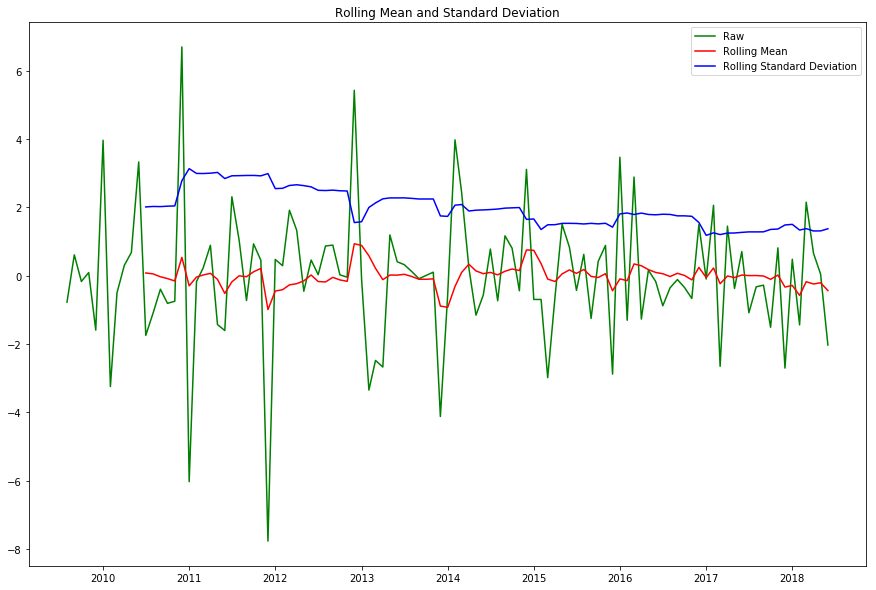

Results of Dickey-Fuller Test:
Test Statistic                 -5.357842
p-value                         0.000004
Lags Used                      11.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [14]:
check_stationarity(train_diff)

After order 1 differencing, we can safely reject the null hypothesis that the transformed series is non-stationary.

## Part 3.3: Autocorrelation and Partial Autocorrelation Functions (ACF and PACF)

Examine the ACF and PACF of the differenced data. We can make some basic guesses about the most appropriate model.


In [15]:
from statsmodels.tsa.stattools import acf, pacf

In [16]:
lag_acf = acf(train_diff.values,nlags = 36)
lag_pacf = pacf(train_diff.values,nlags = 36)

Text(0.5,1,'Partial Autocorrelation Function (PACF)')

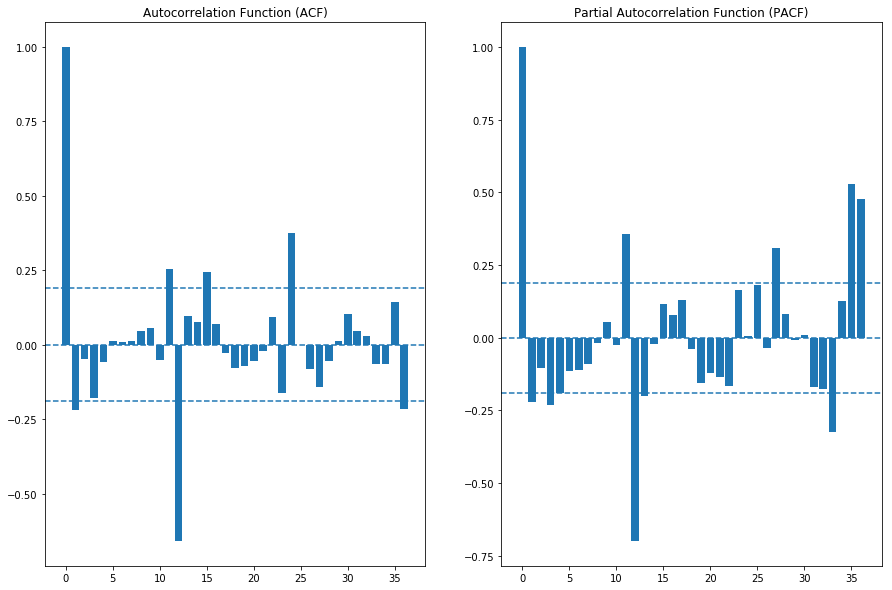

In [17]:
plt.subplot(121)
plt.bar(left = range(len(lag_acf)), height = lag_acf)
plt.axhline(y=0,linestyle='--') # 0 line
plt.axhline(y=-1.96/np.sqrt(len(train_diff)),linestyle = '--') # lower 95% confidence interval boundary
plt.axhline(y=1.96/np.sqrt(len(train_diff)),linestyle = '--') # upper 95% confidence interval boundary
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plt.bar(left = range(len(lag_pacf)), height = lag_pacf)
plt.axhline(y=0,linestyle='--') # 0 line
plt.axhline(y=-1.96/np.sqrt(len(train_diff)),linestyle = '--') # lower 95% confidence interval boundary
plt.axhline(y=1.96/np.sqrt(len(train_diff)),linestyle = '--') # upper 95% confidence interval boundary
plt.title('Partial Autocorrelation Function (PACF)')

Seasonal behavior: we see that for both ACF and PACF we have significant autocorrelation near seasonal (12, 24, 36) lags, and PACF has a significant spike at 12 lags and thus SAR(1).

Non-seasonal behavior: The PACF shows a clear spike at lag 1 and thus AR(1). The ACF also has a tapering pattern in the early lags (and seasonal lags). This is indicative of an MA(1) component.

## Part 3.3: Seasonal ARIMA Model

We’ll use a grid search over the possible combinations on AR and MA terms (limited to a maximum order of 2).

In [18]:
from statsmodels.tsa.arima_model import ARIMA

In [19]:
#p = periods taken for autoregressive model
#d = order of itegration
#q = periods in moving average model
import itertools

# Define the p, d and q  parameters to make any value between 0 and 2, inclusive.
p = q = range(3)

# Generate all different combinations of p, d and q triplets.
pq = list(itertools.product(p,q))
# Generate all different combinations of seasonal p, d and q triplets.
seasonal_pdq = [(x[0], 1, x[1], 12) for x in pq]

# Divide the training set into a subtraining set and a validation set

minAIC = float('inf')
for param in pq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order = (param[0],1,param[1]),
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            aic = results.aic
            if aic < minAIC:
                minAIC = aic
                minParam = param
                minParamSeasonal = param_seasonal
            print('ARIMA{}x{}- AIC:{}'.format((param[0],1,param[1]),param_seasonal,aic))
        except:
            continue
print('Best ARIMA{}x{}-AIC:{}'.format((param[0],1,param[1]), minParamSeasonal, minAIC))

ARIMA(0, 1, 0)x(0, 1, 0, 12)- AIC:445.88865356815387
ARIMA(0, 1, 0)x(0, 1, 1, 12)- AIC:334.1465243062096
ARIMA(0, 1, 0)x(0, 1, 2, 12)- AIC:276.5303688523867
ARIMA(0, 1, 0)x(1, 1, 0, 12)- AIC:332.38010937650836
ARIMA(0, 1, 0)x(1, 1, 1, 12)- AIC:330.22585828405244
ARIMA(0, 1, 0)x(1, 1, 2, 12)- AIC:271.12025643321647
ARIMA(0, 1, 0)x(2, 1, 0, 12)- AIC:271.10909154601313
ARIMA(0, 1, 0)x(2, 1, 1, 12)- AIC:273.10721561655026
ARIMA(0, 1, 0)x(2, 1, 2, 12)- AIC:272.90953108292274
ARIMA(0, 1, 1)x(0, 1, 0, 12)- AIC:437.0826365013928
ARIMA(0, 1, 1)x(0, 1, 1, 12)- AIC:333.5988368255449
ARIMA(0, 1, 1)x(0, 1, 2, 12)- AIC:275.6702609436423
ARIMA(0, 1, 1)x(1, 1, 0, 12)- AIC:333.6593518048652
ARIMA(0, 1, 1)x(1, 1, 1, 12)- AIC:329.077769097126
ARIMA(0, 1, 1)x(1, 1, 2, 12)- AIC:269.77120157926856
ARIMA(0, 1, 1)x(2, 1, 0, 12)- AIC:273.06201732708234
ARIMA(0, 1, 1)x(2, 1, 1, 12)- AIC:275.05497355791357
ARIMA(0, 1, 1)x(2, 1, 2, 12)- AIC:271.9789139047681
ARIMA(0, 1, 2)x(0, 1, 0, 12)- AIC:430.2552762833903
ARI

We will use the best combination of parameters to fit the model.

### Tuning the ARIMA Model

In [20]:
# The grid search gives best Seasonal ARIMA(2,1, 2)x(1, 1, 2, 12) based on the lowest AIC.

mod = sm.tsa.statespace.SARIMAX(train,
                                order = (2,1,2),
                                seasonal_order=(1,1,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

TSresults = mod.fit()
print(TSresults.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0225      0.179     -0.126      0.900      -0.374       0.329
ar.L2          0.6729      0.157      4.284      0.000       0.365       0.981
ma.L1         -0.0548      0.143     -0.382      0.702      -0.336       0.226
ma.L2         -0.8856      0.150     -5.912      0.000      -1.179      -0.592
ar.S.L12      -0.5592      0.184     -3.042      0.002      -0.920      -0.199
ma.S.L12      -0.1336      0.228     -0.585      0.558      -0.581       0.314
ma.S.L24       0.0982      0.152      0.646      0.518      -0.200       0.396
sigma2         1.3421      0.217      6.195      0.000       0.918       1.767


However, the performance table shows ar.L1, ma.L1, ma.S.L12 and ma.S.L24 has high P>|z| values. Next let's try out the following model: Seasonal ARIMA(1, 1, 1)x(1, 1, 0, 12)

In [22]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order = (1,1,1),
                                seasonal_order=(1,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

TSresults = mod.fit()
print(TSresults.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6415      0.078      8.216      0.000       0.488       0.795
ma.L1         -0.8813      0.092     -9.605      0.000      -1.061      -0.702
ar.S.L12      -0.6830      0.055    -12.510      0.000      -0.790      -0.576
sigma2         1.7195      0.173      9.923      0.000       1.380       2.059


Since all the P>|z| values are either less than or close to threshold 0.05, we can use this model to perfom time series forecast.

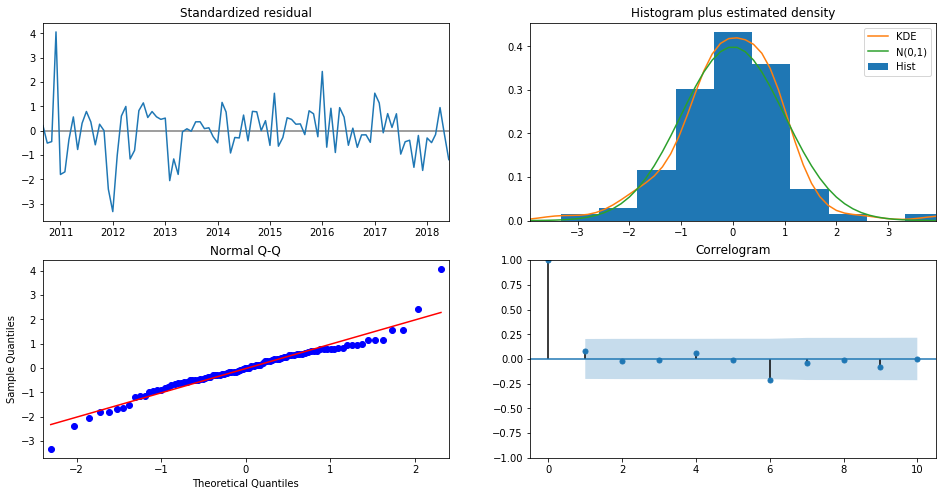

In [23]:
# Check if the residuals are white noise
TSresults.plot_diagnostics(figsize=(16, 8))
plt.show()

Residuals are close to normal distribution and zero mean, which is one of the underlining assumptions of the model.

# Part 4: Validating Predictions

In [24]:
# Get in-sample prediction
pred = TSresults.get_prediction(start=pd.to_datetime('7/1/2008'), dynamic=False)
pred_ci = pred.conf_int() # obtain 95% confidence interval of training set

# Get out-of-sample forecast
forecast = TSresults.get_forecast(steps = len(test))
forecast_ci = forecast.conf_int() # obtain 95% confidence interval of test set

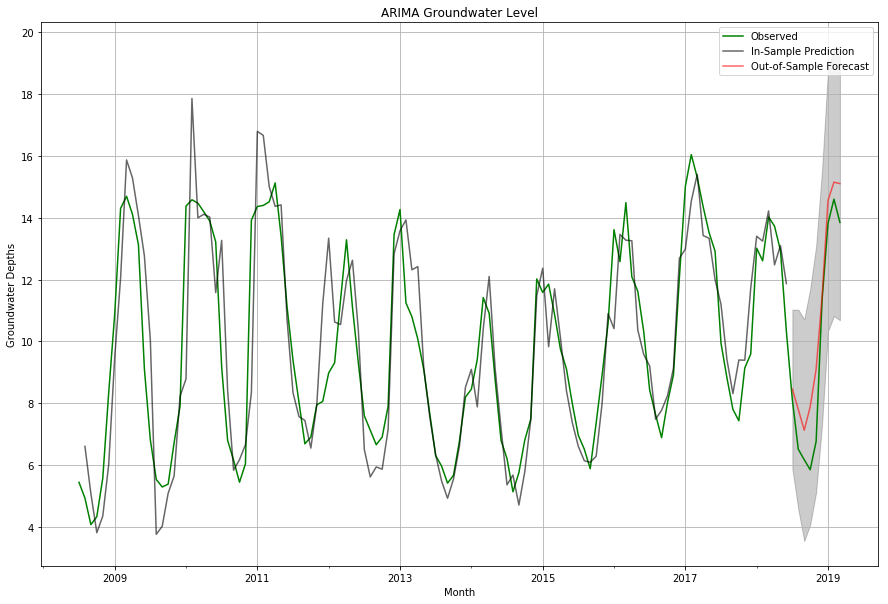

In [25]:
# Plot

ax = gw.plot(label='Observed', color = 'g')

pred.predicted_mean[1:].plot(ax=ax, label='In-Sample Prediction', alpha=.6,color = 'k')
#ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)

forecast.predicted_mean.plot(ax=ax, label='Out-of-Sample Forecast', alpha=.6,color = 'r')
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Month')
ax.set_ylabel('Groundwater Depths')
ax.set_title('ARIMA Groundwater Level')

plt.legend(loc = 'best')
ax.grid()

plt.show()

Then the fitting on training set and prediction on the test set looks reasonally well. Let's take a detailed look at the mean-squared-error for the training set and test set.

### Mean-Squared-Error for the Training and Test Set

In [26]:
from sklearn.metrics import mean_squared_error
print('The Mean Squared Error of ARIMA training is {}'.format(round(mean_squared_error(pred.predicted_mean,train), 3)))
print('The Mean Squared Error of ARIMA forecast is {}'.format(round(mean_squared_error(forecast.predicted_mean[:len(test)],test), 3)))

The Mean Squared Error of ARIMA training is 2.585
The Mean Squared Error of ARIMA forecast is 1.635


# Part 5: Forecast

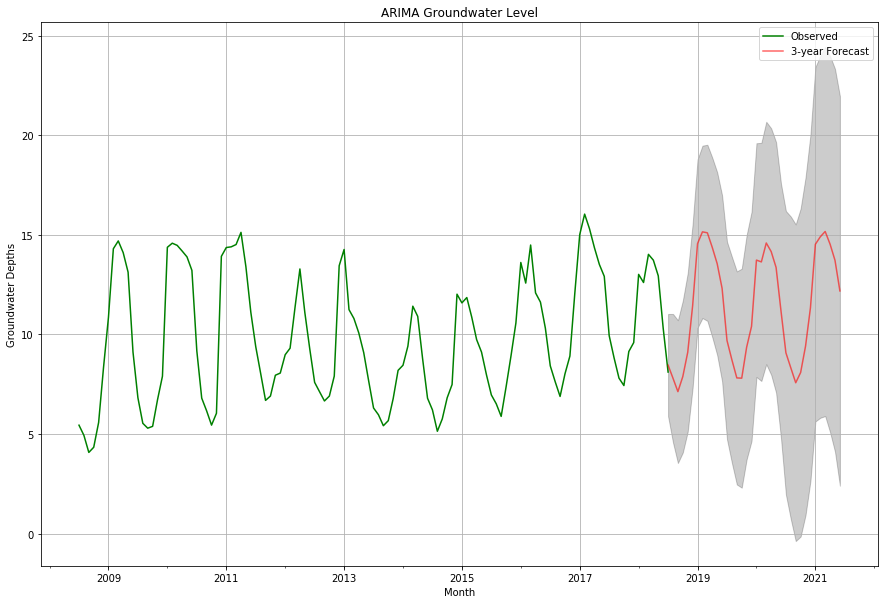

In [27]:
# 3-year forecast
forecast = TSresults.get_forecast(steps = 36)
forecast_ci = forecast.conf_int()

ax = gw[:'7/1/2018'].plot(label='Observed', color = 'g')

forecast.predicted_mean.plot(ax=ax, label='3-year Forecast', alpha=.6,color = 'r')
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('Groundwater Depths')
ax.set_title('ARIMA Groundwater Level')
plt.legend(loc = 'best')

ax.grid()
plt.show()